In [16]:
import warnings
warnings.filterwarnings("ignore")
from torchmetrics.classification import BinaryF1Score as F1Score
import matplotlib.pyplot as plt
from anomalib.models import Padim
from anomalib.engine import Engine
from anomalib.data import PredictDataset, MVTec
from anomalib import TaskType
from anomalib.deploy import ExportType
from anomalib.utils.visualization.image import ImageVisualizer, VisualizationMode, ImageResult
from anomalib.metrics import AUROC
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from PIL import Image
from pynvml.smi import nvidia_smi
import numpy as np
from pathlib import Path
from timeit import default_timer as timer
import re
import sys
import psutil
import shutil
sys.path.append("anomalib_trt_python")
from anomalib_trt_python.trt_inferencer import TrtInferencer
import json
import torch
torch.set_float32_matmul_precision('high')
torch.manual_seed(21)
np.random.seed(21)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nvsmi = nvidia_smi.getInstance()
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))
task = TaskType.SEGMENTATION

Using device: cuda
NVIDIA GeForce RTX 4070 Laptop GPU


In [17]:
# Choose a category
categories = ['transistor', 'bottle', 'carpet', 'hazelnut', 'screw']
category = categories[3] # hazelnut

# Choose a test folder for inference
specific_folder = "crack"
inference_path = Path(f'MVTec_test/{category}/test/{specific_folder}')

# Create folder for category
import os
if not os.path.exists(f"./{category}"):
    os.makedirs(f"./{category}")

In [18]:
def test_model(engine, data, inference, model=None):
    img_visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
    output_images = []
    total_time = 0
    inferences = ['trt', 'torch_fp32', 'torch_fp16']
    if inference not in inferences:
        raise ValueError(f'Invalid inference type. Choose from {inferences}')
    if inference == 'trt':
        for img_path in data:
            time_0 = timer()
            pred_img_result = engine.predict(img_path)
            time_1 = timer()
            if inference != 'trt':
                max_memory_allocated = psutil.virtual_memory().used
            else:
                max_memory_allocated = nvsmi.DeviceQuery('memory.used')
                max_memory_allocated = max_memory_allocated['gpu'][0]['fb_memory_usage']['used']
            inference_time = time_1 - time_0
            total_time += inference_time
            gt = re.sub(r'\btest\b', 'ground_truth', img_path)
            gt = re.sub(r'\b.png\b', '_mask.png', gt)
            if pred_img_result.image.shape[:2] == (256, 256):
                gt_img = np.array(Image.open(gt).resize((256, 256)))
            else:
                gt_img = np.array(Image.open(gt))
            pred_img_result.gt_mask = gt_img
            output_images.append((img_visualizer.visualize_image(pred_img_result), pred_img_result))
    else:
        # data is a dataloader
        if model is None:
            raise ValueError('Model is required for torch inference')
        model.eval()
        model.to(device)
        if inference == 'torch_fp16':
            with autocast():
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()
                time_0 = timer()
                predictions = engine.predict(model, data)
                time_1 = timer()
                max_memory_allocated = torch.cuda.max_memory_allocated(device)
                total_time = time_1 - time_0
        else:
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            time_0 = timer()
            predictions = engine.predict(model, data)
            time_1 = timer()
            max_memory_allocated = torch.cuda.max_memory_allocated(device)
            total_time = time_1 - time_0
        for i in range(len(predictions)):
            pred = predictions[i]
            image_path = pred["image_path"][0]
            image_size = pred["image"].shape[-2:]
            image = np.array(Image.open(image_path).resize(image_size))
            anomaly_map = pred["anomaly_maps"][0]
            anomaly_map = anomaly_map.cpu().numpy().squeeze()
            gt = re.sub(r'\btest\b', 'ground_truth', image_path)
            gt = re.sub(r'\b.png\b', '_mask.png', gt)
            visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
            image_result = ImageResult(
                            image=image,
                            pred_score=pred["pred_scores"][0].cpu().numpy().item() if "pred_scores" in pred else None,
                            pred_label=pred["pred_labels"][0].cpu().numpy().item() if "pred_labels" in pred else None,
                            anomaly_map=pred["anomaly_maps"][0].cpu().numpy() if "anomaly_maps" in pred else None,
                            pred_mask=pred["pred_masks"][0].squeeze().int().cpu().numpy() if "pred_masks" in pred else None,
                            gt_mask=pred["mask"][0].squeeze().int().cpu().numpy() if "mask" in pred else None,
                            gt_boxes=pred["boxes"][0].cpu().numpy() if "boxes" in pred else None,
                            pred_boxes=pred["pred_boxes"][0].cpu().numpy() if "pred_boxes" in pred else None,
                            box_labels=pred["box_labels"][0].cpu().numpy() if "box_labels" in pred else None,
                        )
            gt_img_np = np.array(Image.open(gt).resize(image_size))
            image_result.gt_mask = gt_img_np
            output_images.append((visualizer.visualize_image(image_result), image_result))
    
    sum_f1_pixel = 0
    sum_f1_img = 0
    sum_auroc_pixel = 0
    sum_auroc_img = 0
    fig, ax = plt.subplots(len(output_images), 1, figsize=(20, 20))
    i = 0
    for img, pred_img_result in output_images:
        if len(output_images) > 1:
            ax[i].imshow(img)
            ax[i].axis('off')
            i += 1
        else:
            ax.imshow(img)
            ax.axis('off')


        auroc = AUROC().to(device)
        pred_mask = torch.from_numpy(pred_img_result.pred_mask).to(device)
        gt_mask = torch.from_numpy(pred_img_result.gt_mask).to(device)
        image_scores = torch.mean(pred_mask.view(pred_mask.shape[0], -1).float(), dim=1)
        gt_image_labels = torch.any(gt_mask.view(gt_mask.shape[0], -1) > 0, dim=1).long()
        img_lvl_auroc = auroc(image_scores, gt_image_labels)

        gt_mask = torch.where(gt_mask > 0, torch.tensor(1, device=gt_mask.device), torch.tensor(0, device=gt_mask.device))
        pred_mask_flat = pred_mask.view(-1).float()
        gt_mask_flat = gt_mask.view(-1).long()
        pixel_lvl_auroc = auroc(pred_mask_flat, gt_mask_flat)

        f1_score = F1Score().to(device)
        pixel_lvl_f1 = f1_score(pred_mask_flat, gt_mask_flat)
        img_lvl_f1 = f1_score(image_scores, gt_image_labels)
        sum_f1_pixel += pixel_lvl_f1
        sum_f1_img += img_lvl_f1
        sum_auroc_pixel += pixel_lvl_auroc
        sum_auroc_img += img_lvl_auroc
    print(f'Average pixel-level F1 score: {sum_f1_pixel / len(output_images)}')
    print(f'Average image-level F1 score: {sum_f1_img / len(output_images)}')
    print(f'Average pixel-level AUROC: {sum_auroc_pixel / len(output_images)}')
    print(f'Average image-level AUROC: {sum_auroc_img / len(output_images)}')
    output_path = Path(f'./{category}/output_{inference}.png')
    fig.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0)
    return output_path, total_time, max_memory_allocated, output_images


In [19]:
# Torch FP32 model
model_fp32 = Padim(backbone='wide_resnet50_2')
engine_fp32 = Engine()

fit = True # Set to True if you want to retrain the model, if False and model exists, it will be loaded from disk

if Path(f"./{category}/padim_fp32_torch.pth").exists() and not fit:
    model_fp32.load_state_dict(torch.load(f"./{category}/padim_fp32_torch.pth"))
    print("Loaded model from disk")
else:
    dataset_fit = Path("./MVTec_fit")
    datamodule_fp32 = MVTec(
        root=dataset_fit,
        category=category,
        image_size=256,
        train_batch_size=32,
        eval_batch_size=32,
        num_workers=4,
        task=task
    )
    # Train the model
    engine_fp32.fit(datamodule=datamodule_fp32, model=model_fp32)
    print("Model trained")
    # Save the fp32 model
    torch.save(model_fp32.state_dict(), f"./{category}/padim_fp32_torch.pth")
    print("Model saved to disk")


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │ 24.9 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 24.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.9 M                                                                                               
Total estimated model params size (MB): 99

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Model trained
Model saved to disk


ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Average pixel-level F1 score: 0.613380491733551
Average image-level F1 score: 0.8020370602607727
Average pixel-level AUROC: 0.8756765723228455
Average image-level AUROC: 0.8638681769371033
Time taken for inference (FP32): 2.99 seconds, memory used: 5.03 GB


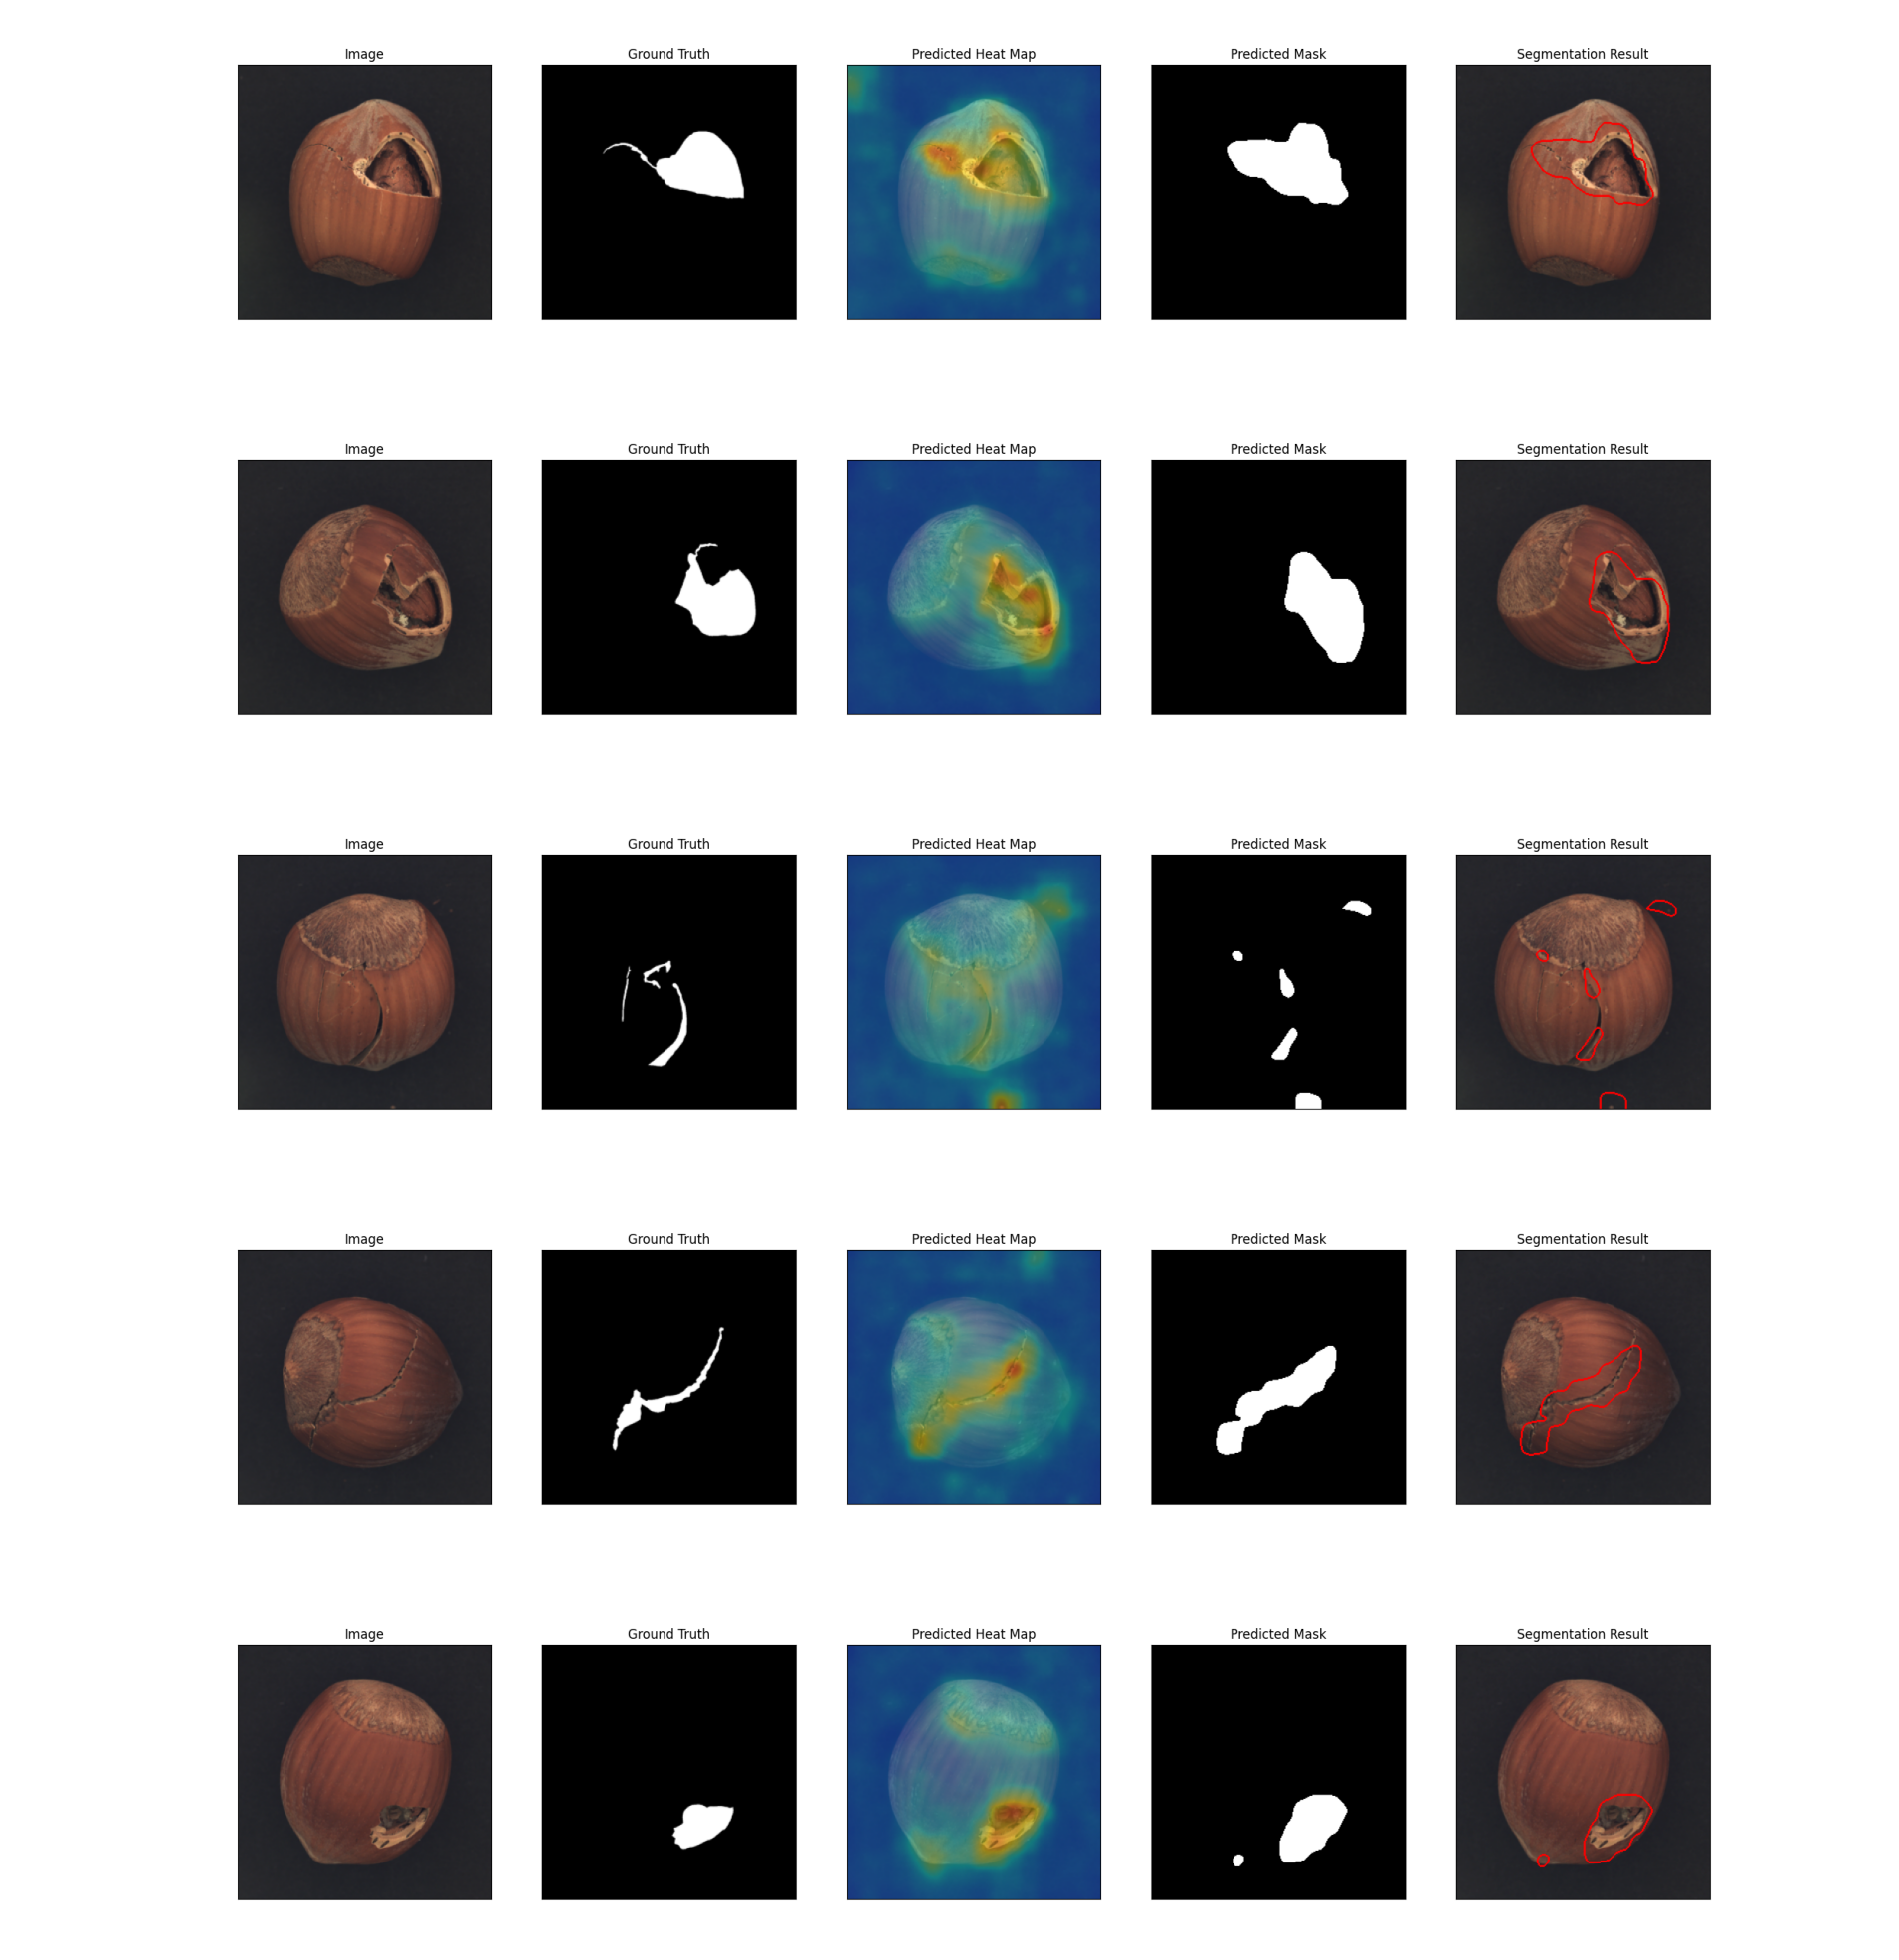

In [20]:
# Inference FP32 model
inference_dataset_fp32 = PredictDataset(path=inference_path)
inference_dataloader_fp32 = DataLoader(dataset=inference_dataset_fp32)

output_path_FP32, inference_time_FP32, memory_FP32, fp32_output_images = test_model(engine_fp32, inference_dataloader_fp32, 'torch_fp32', model=model_fp32)
print(f"Time taken for inference (FP32): {inference_time_FP32:.2f} seconds, memory used: {memory_FP32 / 1024**3:.2f} GB")
Image.open(output_path_FP32)

In [21]:
# Torch FP16 model
#
# Load the FP32 model and convert it to FP16
# If the FP16 model already exists and fit is False, load it from disk
if Path(f"./{category}/padim_fp16_torch.pth").exists() and not fit:
    model_fp16 = Padim(backbone='wide_resnet50_2')
    model_fp16.load_state_dict(torch.load(f"./{category}/padim_fp16_torch.pth"))
    print("Loaded model from disk")
# Convert the FP32 model to FP16 and save it to disk if it doesn't exist or fit is True
else:
    model_fp32_to_16 = Padim(backbone='wide_resnet50_2')
    model_fp32_to_16.load_state_dict(torch.load(f"./{category}/padim_fp32_torch.pth"))
    model_fp16 = model_fp32_to_16.half()
    print("Converted the FP32 model and saved it to disk")
    # Save the FP16 model
    torch.save(model_fp16.state_dict(), f"./{category}/padim_fp16_torch.pth")

Converted the FP32 model and saved it to disk


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Average pixel-level F1 score: 0.6135696172714233
Average image-level F1 score: 0.8033933639526367
Average pixel-level AUROC: 0.8762359023094177
Average image-level AUROC: 0.8654422163963318
Time taken for inference: 1.81 seconds, memory used: 2.49 GB


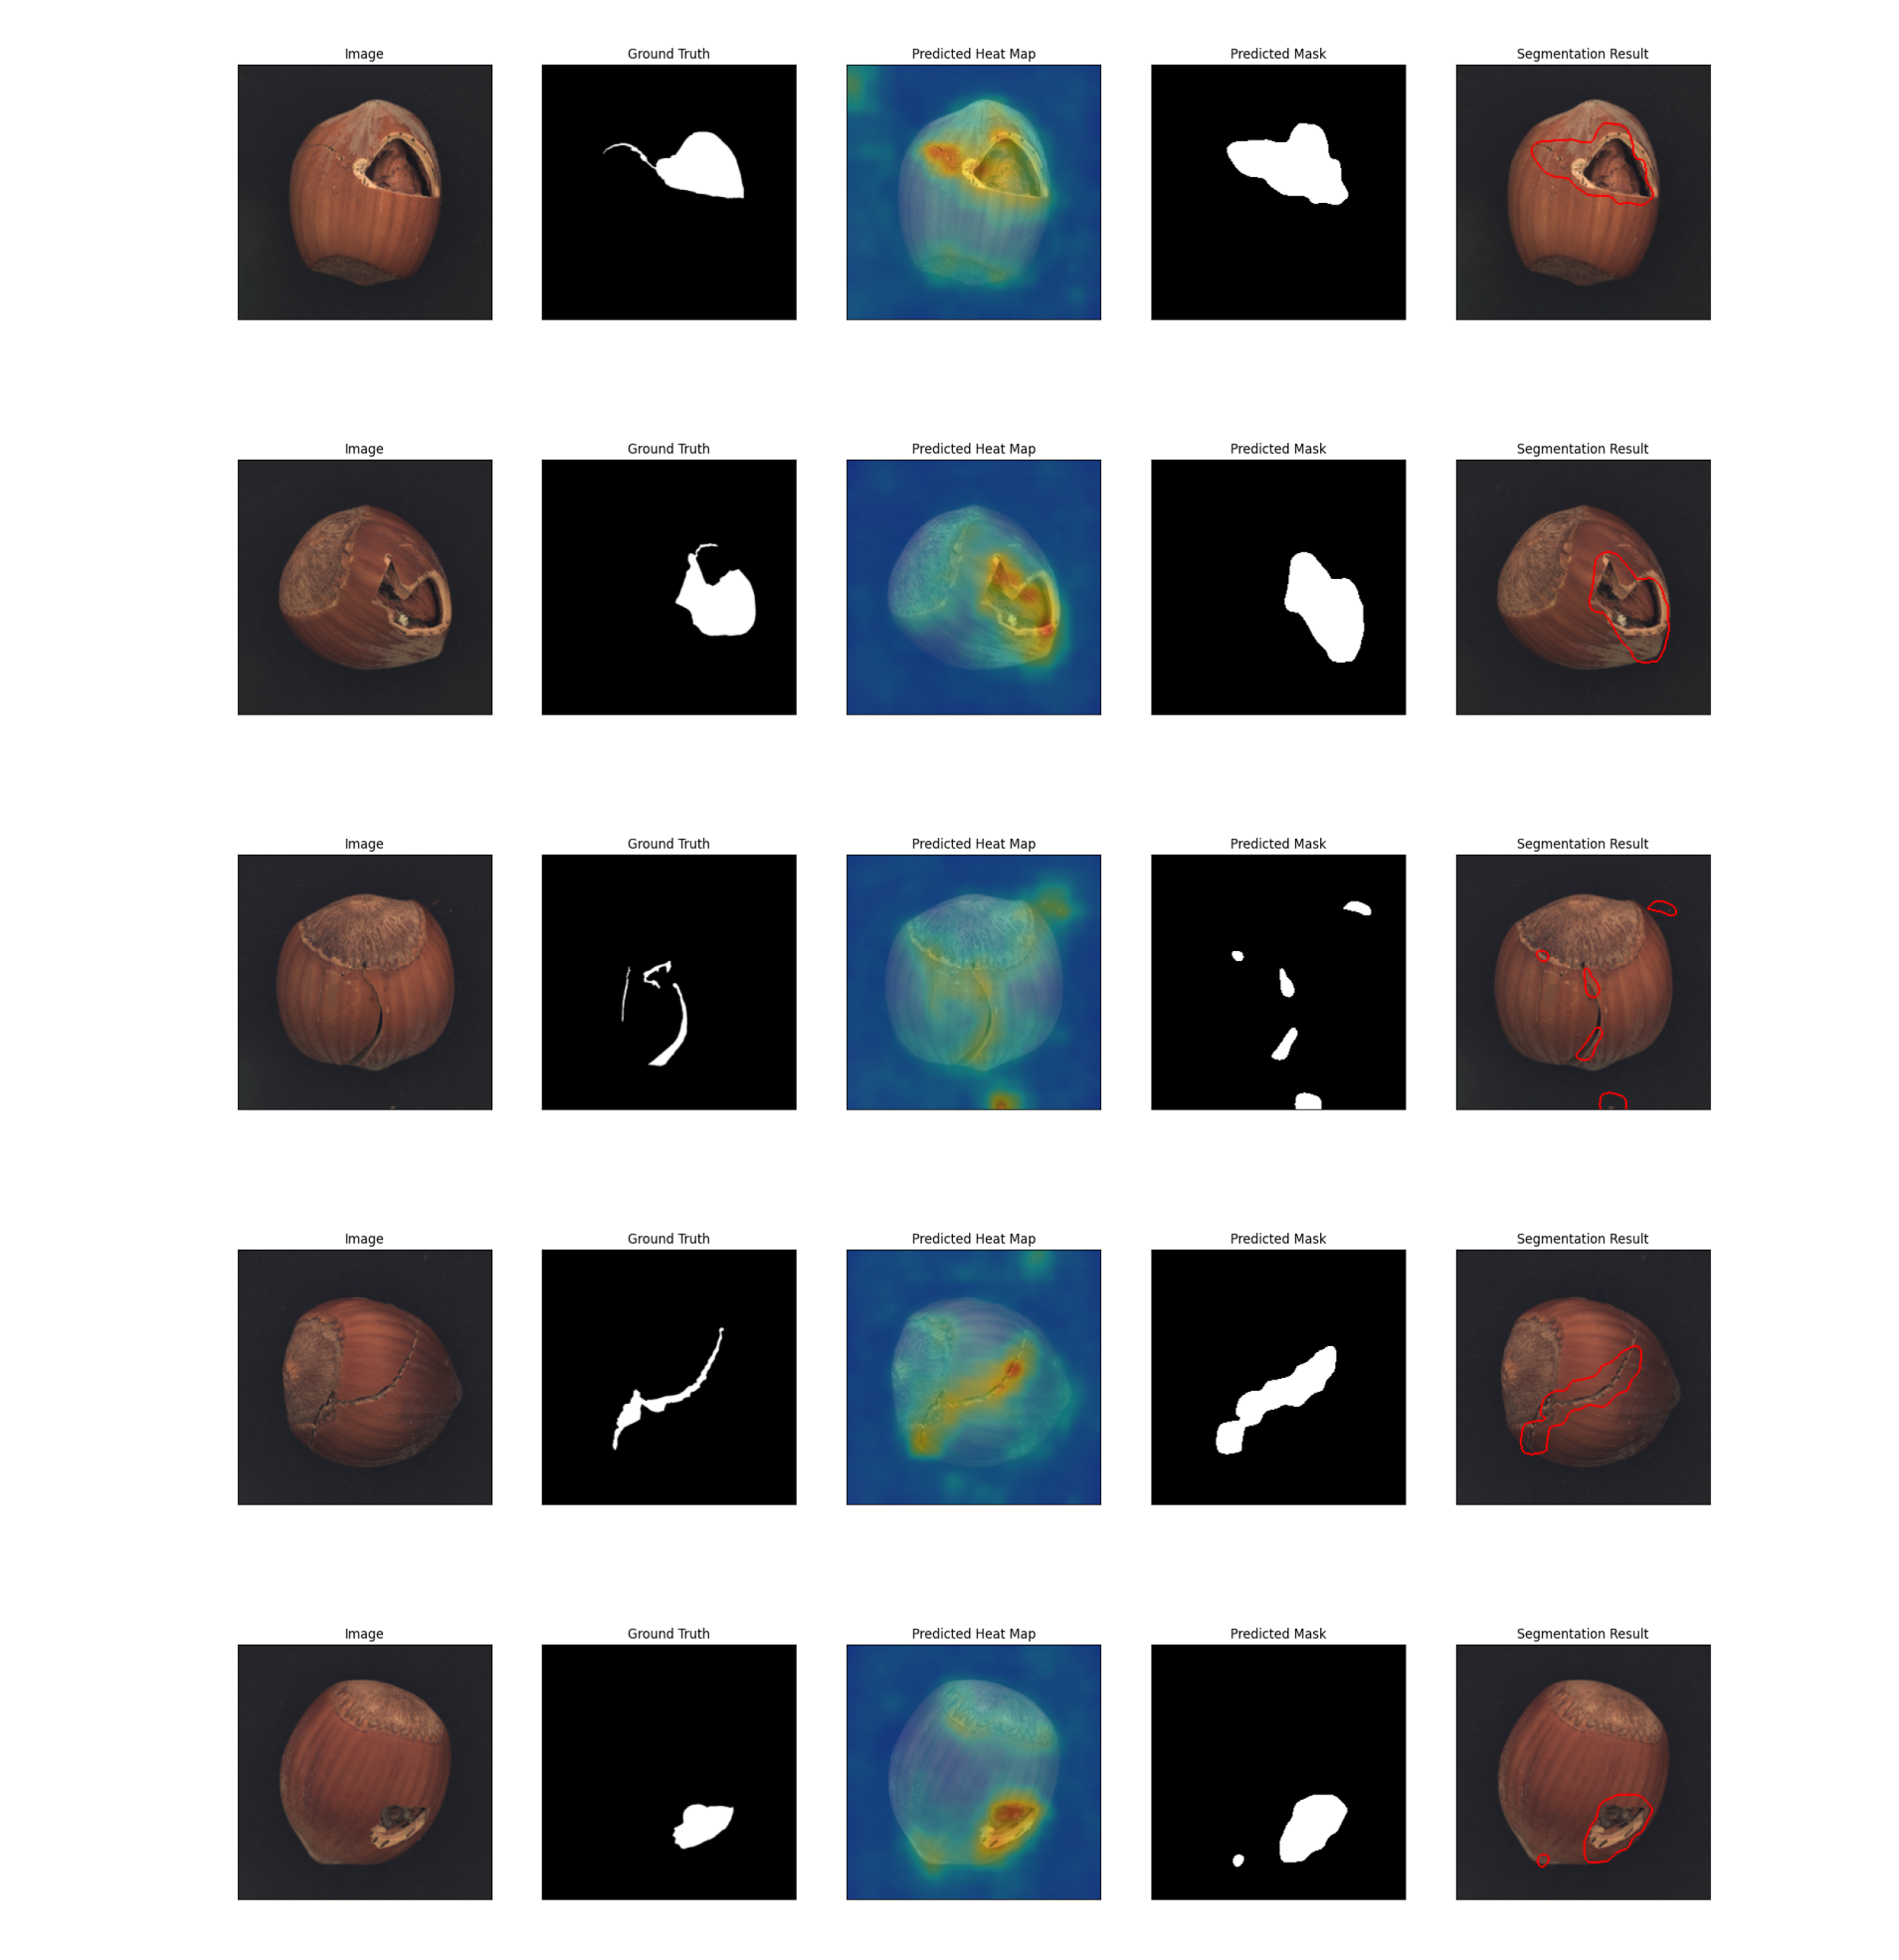

In [22]:
engine_fp16 = Engine()

# Inference FP16 model
inference_dataset_fp16 = PredictDataset(path=inference_path)
inference_dataloader_fp16 = DataLoader(dataset=inference_dataset_fp16)

output_path_fp16, inference_time_fp16, memory_fp16, fp_16_output_images = test_model(engine_fp16, inference_dataloader_fp16, 'torch_fp16', model_fp16)
print(f"Time taken for inference: {inference_time_fp16:.2f} seconds, memory used: {memory_fp16 / 1024**3:.2f} GB")
Image.open(output_path_fp16)

In [23]:
# ONNX FP32 model
# This step is needed to convert the model to TensorRT, inference will be done using the TensorRT model on the GPU
#
# Export from Torch FP32 to ONNX
# If the ONNX model already exists and fit is False, load it from disk
if Path(f"./{category}/padim_fp32_onnx/weights/onnx/model.onnx").exists() and not fit:
    print("ONNX model already exists")
# Export the model to ONNX and save it to disk if it doesn't exist or fit is True
else:
    model_fp32.eval()
    # Delete the folder if it exists to avoid errors
    if Path(f"./{category}/padim_fp32_onnx").exists():
        shutil.rmtree(f"./{category}/padim_fp32_onnx")
    engine_fp32.export(model=model_fp32, export_type=ExportType.ONNX, export_root=f'./{category}/padim_fp32_onnx', input_size=(256, 256))
    print("ONNX model exported and saved to disk")

ONNX model exported and saved to disk


In [24]:
# From ONNX to TensorRT
# If the TensorRT engine already exists and fit is False, load it from disk
if Path(f"./{category}/padim_fp32_trt.engine").exists() and not fit:
    print("TensorRT engine already exists")
# Convert the ONNX model to TensorRT and save it to disk if it doesn't exist or fit is True
else:
    onnx_path = f"./{category}/padim_fp32_onnx/weights/onnx/model.onnx"
    engine_path = f"./{category}/padim_fp32_trt.engine"
    !trtexec --onnx={onnx_path} --saveEngine={engine_path}
    print("TensorRT engine created and saved to disk")

TensorRT engine created and saved to disk&&&& RUNNING TensorRT.trtexec [TensorRT v100100] # trtexec --onnx=./hazelnut/padim_fp32_onnx/weights/onnx/model.onnx --saveEngine=./hazelnut/padim_fp32_trt.engine
[07/11/2024-23:15:52] [I] === Model Options ===
[07/11/2024-23:15:52] [I] Format: ONNX
[07/11/2024-23:15:52] [I] Model: ./hazelnut/padim_fp32_onnx/weights/onnx/model.onnx
[07/11/2024-23:15:52] [I] Output:
[07/11/2024-23:15:52] [I] === Build Options ===
[07/11/2024-23:15:52] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[07/11/2024-23:15:52] [I] avgTiming: 8
[07/11/2024-23:15:52] [I] Precision: FP32
[07/11/2024-23:15:52] [I] LayerPrecisions: 
[07/11/2024-23:15:52] [I] Layer Device Types: 
[07/11/2024-23:15:52] [I] Calibration: 
[07/11/2024-23:15:52] [I] Refit: Disabled
[07/11/2024-23:15:52] [I] Strip weights: Disabled
[07/11/2024-23:15:52] [I] Version Compatible: Disabled
[07/11/2024-23:15:52] [I] ONNX Plu

[07/11/2024-23:22:27] [W] * GPU compute time is unstable, with coefficient of variance = 2.89941%.
[07/11/2024-23:22:27] [W]   If not already in use, locking GPU clock frequency or adding --useSpinWait may improve the stability.


Reading metadata from file metadata_padim.json...
metadata:  {'task': 'segmentation', 'transform': {'__version__': '1.3.1', 'transform': {'__class_fullname__': 'Compose', 'p': 1.0, 'transforms': [{'__class_fullname__': 'Resize', 'always_apply': True, 'p': 1, 'height': 256, 'width': 256, 'interpolation': 1}, {'__class_fullname__': 'Normalize', 'always_apply': False, 'p': 1.0, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'max_pixel_value': 255.0}, {'__class_fullname__': 'ToTensorV2', 'always_apply': True, 'p': 1.0, 'transpose_mask': False}], 'bbox_params': None, 'keypoint_params': None, 'additional_targets': {'image': 'image', 'depth_image': 'image'}, 'is_check_shapes': True}}, 'image_threshold': 176.62171936035156, 'pixel_threshold': 139.9947967529297, 'min': 16.932891845703125, 'max': 411.26806640625}
inference batchsize = 1
Reading engine from file ./hazelnut/padim_fp32_trt.engine...
warm up finished...
Average pixel-level F1 score: 0.5879503488540649
Average image-lev

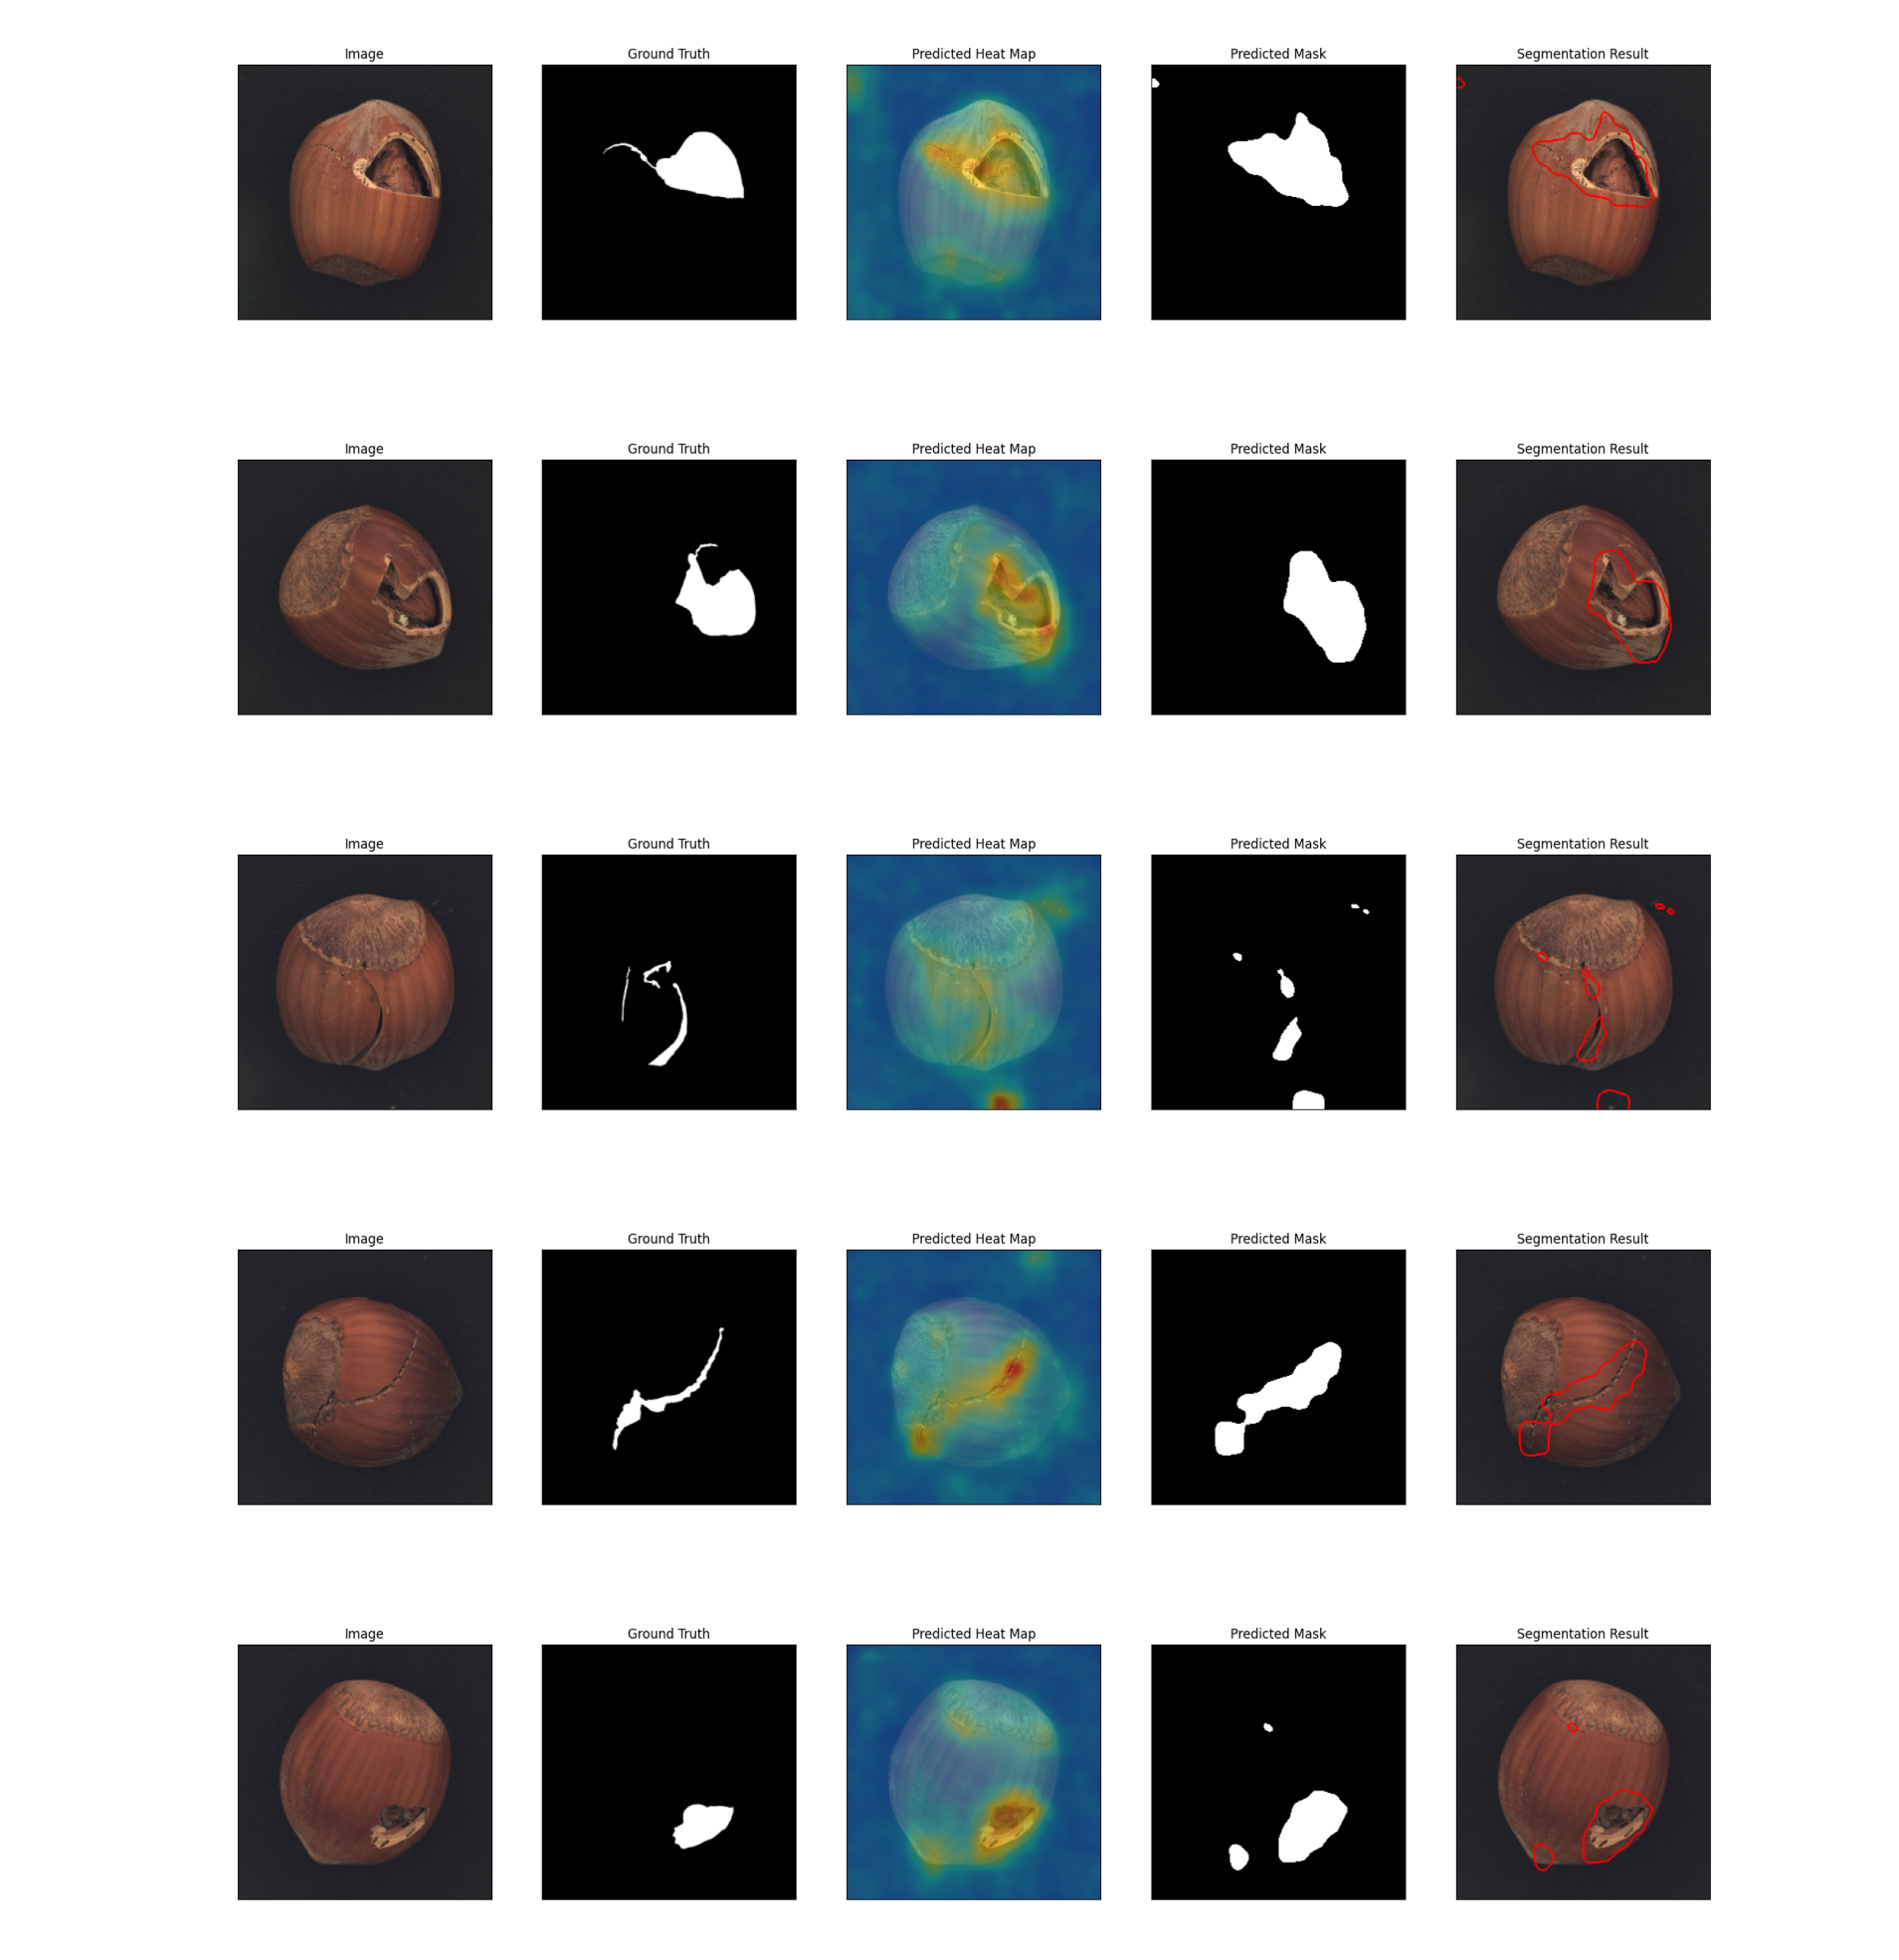

In [25]:
# Update metadata for TensorRT model
metadata_onnx = json.load(open(f"./{category}/padim_fp32_onnx/weights/onnx/metadata.json"))
metadata_padim = json.load(open("metadata_padim.json"))
metadata_padim["image_threshold"] = metadata_onnx["image_threshold"]
metadata_padim["pixel_threshold"] = metadata_onnx["pixel_threshold"]
metadata_padim["min"] = metadata_onnx["min"]
metadata_padim["max"] = metadata_onnx["max"]
with open("metadata_padim.json", 'w') as f:
    json.dump(metadata_padim, f, indent=4)


# Inference TensorRT model
inferencer_trt = TrtInferencer(
    path=f"./{category}/padim_fp32_trt.engine",
    metadata=f"metadata_padim.json",
    task=task
)

data = [str(img) for img in inference_path.glob('*.png')]
output_path_trt, inference_time_trt, memory_trt, trt_output_images = test_model(inferencer_trt, data, 'trt')
print(f"Inference time: {inference_time_trt:.2f} seconds, Memory: {memory_trt/1024:.2f} GB")
Image.open(output_path_trt)

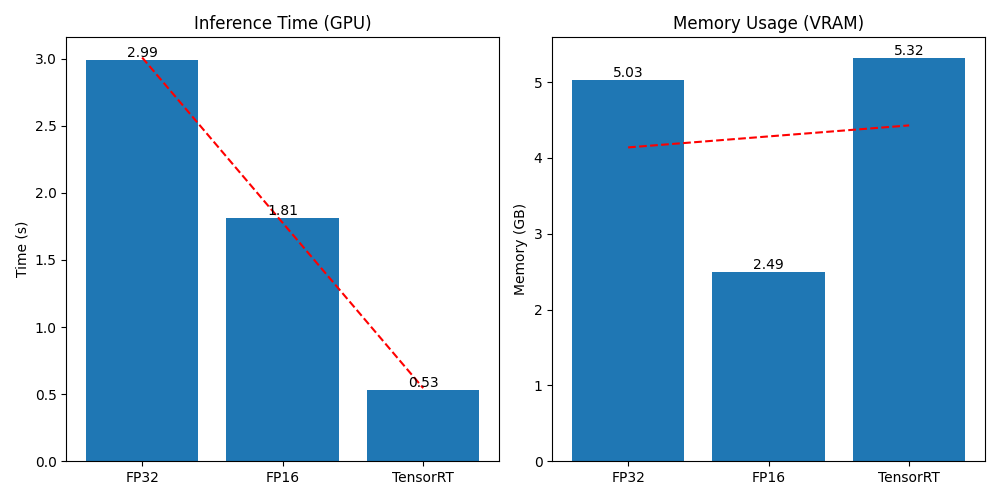

In [26]:
# Comparison of the inference time and memory usage
inference_times = [inference_time_FP32, inference_time_fp16, inference_time_trt]
memory_usage = [memory_FP32 / 1024**3, memory_fp16 / 1024**3, memory_trt / 1024] # Convert to GB

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(['FP32', 'FP16', 'TensorRT'], inference_times)
ax[0].set_title('Inference Time (GPU)')
ax[0].set_ylabel('Time (s)')
ax[1].bar(['FP32', 'FP16', 'TensorRT'], memory_usage)
ax[1].set_title('Memory Usage (VRAM)')
ax[1].set_ylabel('Memory (GB)')
for i, v in enumerate(inference_times):
    ax[0].text(i, v, str(round(v, 2)), ha='center', va='bottom')
for i, v in enumerate(memory_usage):
    ax[1].text(i, v, str(round(v, 2)), ha='center', va='bottom')

z = np.polyfit([0, 1, 2], inference_times, 1)
p = np.poly1d(z)
ax[0].plot([0, 1, 2], p([0, 1, 2]), "r--")
z = np.polyfit([0, 1, 2], memory_usage, 1)
p = np.poly1d(z)
ax[1].plot([0, 1, 2], p([0, 1, 2]), "r--")

plt.tight_layout()
output = Path(f"./{category}/inference_comparison.png")
plt.savefig(output)
Image.open(output)

In [27]:
# Percentage improvement in inference time and memory usage with TensorRT
inference_time_improvement = (inference_time_FP32 - inference_time_trt) / inference_time_FP32 * 100
memory_improvement = (memory_usage[0] - memory_usage[2]) / memory_usage[0] * 100
print(f"Inference time improvement with TensorRT: {inference_time_improvement:.2f}%")
print(f"Memory usage improvement with TensorRT: {memory_improvement:.2f}%")

Inference time improvement with TensorRT: 82.36%
Memory usage improvement with TensorRT: -5.77%


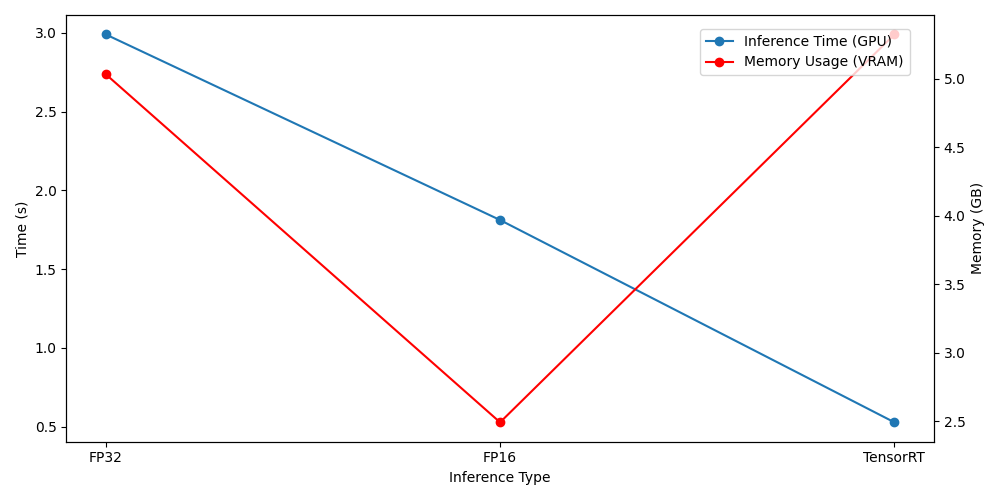

In [28]:
# Ccomparison of the inference time and memory usage using a line plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(['FP32', 'FP16', 'TensorRT'], inference_times, label='Inference Time (GPU)', marker='o')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Inference Type')
ax2 = ax.twinx()
ax2.plot(['FP32', 'FP16', 'TensorRT'], memory_usage, label='Memory Usage (VRAM)', marker='o', color='red')
ax2.set_ylabel('Memory (GB)')
plt.tight_layout()
fig.legend(loc=(0.7, 0.85))
output = Path(f"./{category}/inference_comparison_line.png")
plt.savefig(output)
Image.open(output)

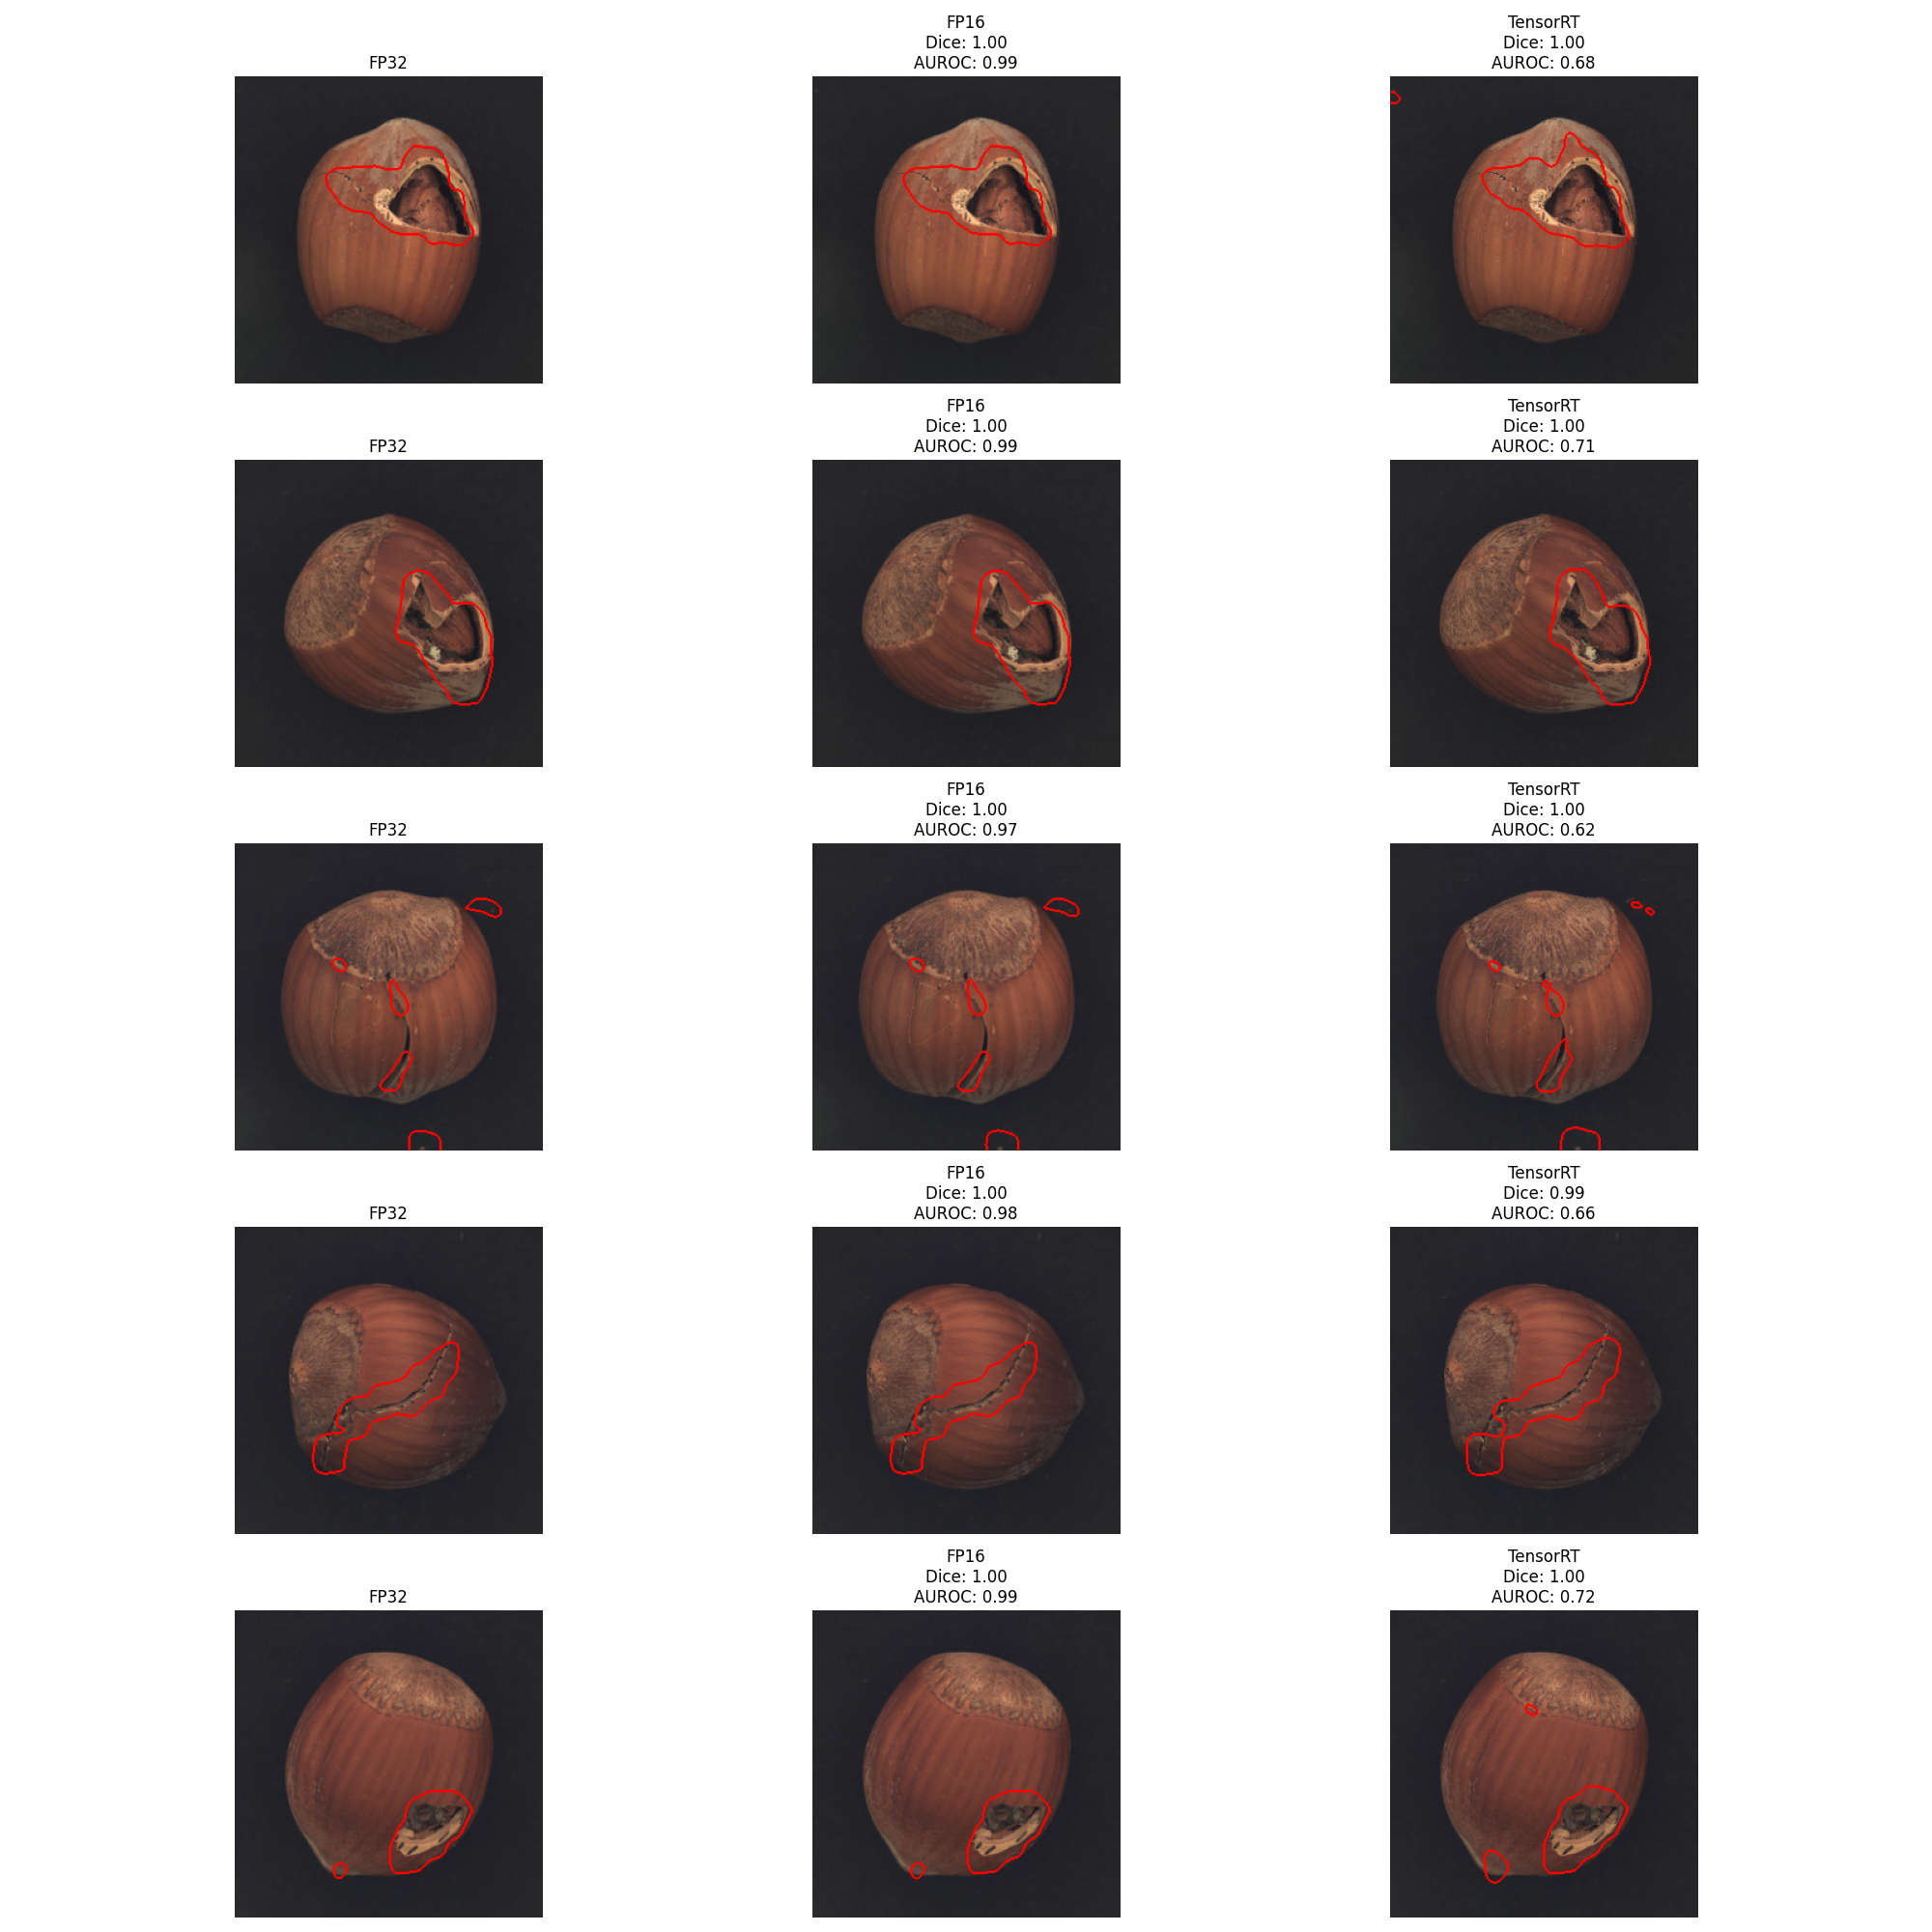

In [33]:
def dice_coefficient(gt_img, pred_img):
    binary_gt = np.where(gt_img > 0, 1, 0).astype(np.uint8)
    binary_pred = np.where(pred_img > 0, 1, 0).astype(np.uint8)
    intersection = np.logical_and(binary_gt, binary_pred)
    dice = (2. * intersection.sum()) / (binary_gt.sum() + binary_pred.sum())
    return dice

def auroc_pixel_level(gt_img, pred_img):
    auroc = AUROC()
    pred_mask = torch.from_numpy(pred_img)
    pred_mask = torch.where(pred_mask > 0, torch.tensor(1), torch.tensor(0))
    gt_mask = torch.from_numpy(gt_img)
    gt_mask = torch.where(gt_mask > 0, torch.tensor(1), torch.tensor(0))
    pred_mask_flat = pred_mask.view(-1).float()
    gt_mask_flat = gt_mask.view(-1).long()
    pixel_lvl_auroc = auroc(pred_mask_flat, gt_mask_flat)
    return pixel_lvl_auroc.item()

# Comparison of the segmentation results of all the images for each inference type
segmentation_results = [fp32_output_images, fp_16_output_images, trt_output_images]
segmentation_results = [segmentation_results[col][row][1].segmentations for row in range(len(segmentation_results[0])) for col in range(len(segmentation_results))]
inferences = ['FP32', 'FP16', 'TensorRT']

# Create a grid of images for comparison
fig, ax = plt.subplots(5, len(inferences), figsize=(20, 20))

# Plot the images row by row
k = 0
for i in range(5):
    for j in range(len(inferences)):
        ax[i, j].imshow(segmentation_results[k + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(inferences[j])
        if j != 0:
            dice = dice_coefficient(segmentation_results[k], segmentation_results[k + j])
            auroc = auroc_pixel_level(segmentation_results[k], segmentation_results[k + j])
            ax[i, j].set_title(f'{inferences[j]}\nDice: {dice:.2f}\nAUROC: {auroc:.2f}')
    k = (j + 1) * (i + 1)
fig.tight_layout()
output_path = Path(f"./{category}/segmentation_comparison.png")
plt.savefig(output_path)
Image.open(output_path)